# How to classify satellite images

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')

In [5]:
results_path = Path ('results', 'eurosat')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load EuroSat Dataset

In [6]:
(raw_train, raw_validation), metadata = tfds.load('eurosat',
                                                  split=[
                                                      tfds.Split.TRAIN.subsplit(
                                                          tfds.percent[:90]),
                                                      tfds.Split.TRAIN.subsplit(
                                                          tfds.percent[90:])
                                                  ],
                                                  with_info=True,
                                                  shuffle_files=False,
                                                  as_supervised=True,
                                                  data_dir='../data/tensorflow')

### Inspect MetaData

In [7]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    version=0.0.1,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    urls=['https://github.com/phelber/eurosat'],
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
       

In [8]:
print('Train:\t', raw_train)
print('Valid:\t', raw_validation)

Train:	 <_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
Valid:	 <_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


### Show sample images

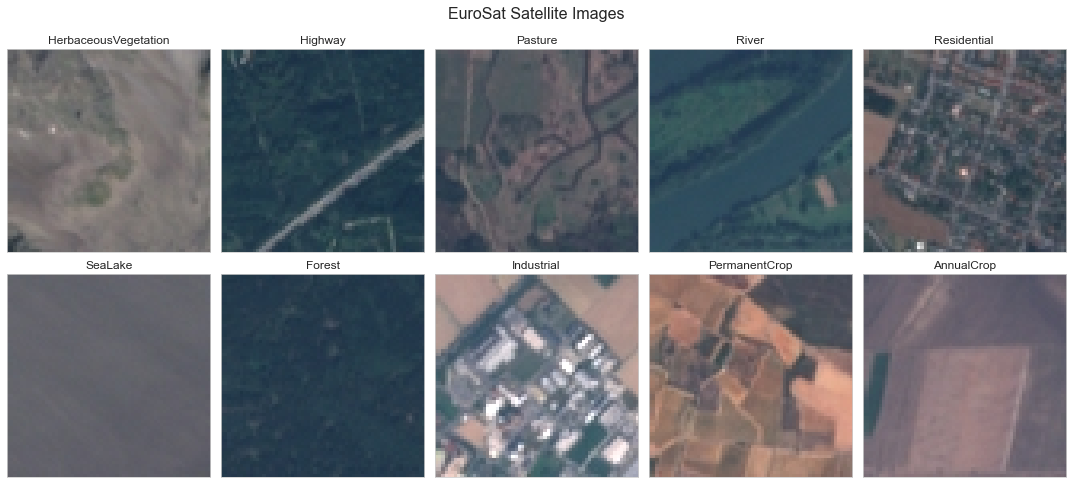

In [9]:
fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
axes = axes.flatten()
get_label_name = metadata.features['label'].int2str
labels = set()
c = 0
for img, label in raw_train.as_numpy_iterator():
    if label not in labels:
        axes[c].imshow(img)
        axes[c].set_title(get_label_name(label))
        axes[c].grid(False)
        axes[c].tick_params(axis='both', 
                            which='both', 
                            bottom=False, 
                            top=False, 
                            labelbottom=False, 
                            right=False, 
                            left=False, 
                            labelleft=False)
        labels.add(label)
        c += 1
        if c == 10:
            break
fig.suptitle('EuroSat Satellite Images', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig(results_path / 'eurosat_samples', dpi=300);

## Preprocessing

All images will be resized to 160x160:

In [10]:
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [11]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

In [12]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)

In [13]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [14]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [15]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 64, 64, 3])

## Load the DenseNet201 Bottleneck Features

In [16]:
densenet = DenseNet201(input_shape=IMG_SHAPE, 
                       include_top=False, 
                       weights='imagenet',
                       pooling='max',
                       classes=1000)

densenet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [17]:
feature_batch = densenet(image_batch)
feature_batch.shape

TensorShape([32, 1920])

In [18]:
len(densenet.layers)

708

## Add new layers to model

In [19]:
model = Sequential([
    densenet,
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [20]:
for layer in model.layers:
    layer.trainable = True

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4

### Compute baseline metrics

In [23]:
initial_epochs = 10
validation_steps = 20

initial_loss, initial_accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 0s 24ms/step - loss: 3255.1558 - accuracy: 0.1063


In [24]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 3255.16 | initial_accuracy accuracy: 10.63%


## Train model

### Define Callbacks

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

In [26]:
eurosat_path = (results_path / 'cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=eurosat_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [27]:
epochs = 100

In [28]:
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches,
                    callbacks=[checkpointer, 
                               early_stopping])

Epoch 1/100
    760/Unknown - 70s 92ms/step - loss: 700.4531 - accuracy: 0.8181
Epoch 00001: val_accuracy improved from -inf to 0.94444, saving model to results/eurosat/cnn.weights.best.hdf5
760/760 [==============================] - 74s 97ms/step - loss: 700.4531 - accuracy: 0.8181 - val_loss: 4.1437 - val_accuracy: 0.9444
Epoch 2/100
760/760 [==============================] - ETA: 0s - loss: 2.5708 - accuracy: 0.9230
Epoch 00002: val_accuracy improved from 0.94444 to 0.94963, saving model to results/eurosat/cnn.weights.best.hdf5
760/760 [==============================] - 75s 98ms/step - loss: 2.5708 - accuracy: 0.9230 - val_loss: 2.3430 - val_accuracy: 0.9496
Epoch 3/100
760/760 [==============================] - ETA: 0s - loss: 2.3192 - accuracy: 0.9536
Epoch 00003: val_accuracy did not improve from 0.94963
760/760 [==============================] - 71s 94ms/step - loss: 2.3192 - accuracy: 0.9536 - val_loss: 2.5888 - val_accuracy: 0.9107
Epoch 4/100
760/760 [========================

### Plot Learning Curves

In [29]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['accuracy', 'val_accuracy']].plot(ax=axes[0], title='Accuracy')
    df[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    fig.tight_layout();

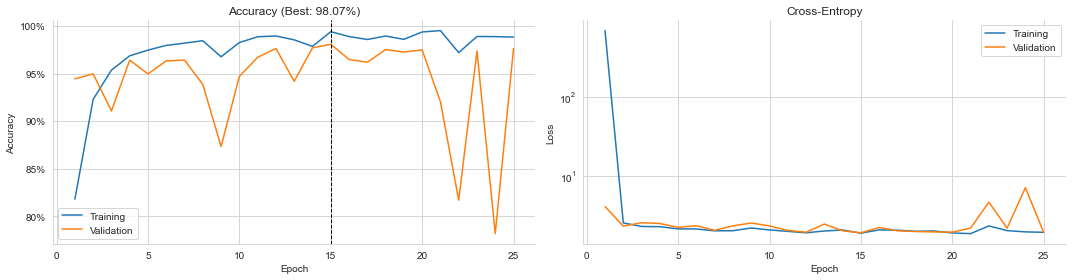

In [30]:
metrics = pd.DataFrame(history.history)
metrics.index = metrics.index.to_series().add(1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics[['accuracy', 'val_accuracy']].plot(ax=axes[0], 
                                           title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})')
axes[0].axvline(metrics.val_accuracy.idxmax(), ls='--', lw=1, c='k')
metrics[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy', logy=True)
for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')
    
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'satellite_accuracy', dpi=300);